# Build a Financial Analyst Tool-Use AI Agent

This project will focus on building a Tool-Use Agentic AI System which acts as a Financial Analyst & Advisor.

![](https://i.imgur.com/sHevAT8.png)


### Financial Analyst Tool-Use Agentic AI System

In this project, we will design a **Financial Analyst Tool-Use Agentic AI System** to assist investors with accurate, up-to-date stock market insights. We will be building the complete agent from scratch using **LangGraph**, a cutting-edge alternative to LangChain. The workflow comprises the following components:

1. **Agent System Prompt**:
   - The agent is designed to validate input queries for relevance and specificity.
   - It provides comprehensive market analysis or stock-specific insights depending on the user's query.
   - For invalid queries, the agent responds professionally and guides the user appropriately.


   **Flows**:
   - **Flow 1**: For general market trends, the agent analyzes data and suggests stock opportunities using tools like `SEARCH_WEB` and `GET_GENERAL_MARKET_DATA`.
   - **Flow 2**: For stock-specific queries, the agent validates the stock ticker, retrieves relevant data, and provides insights using tools such as `GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS` and `GET_STOCK_PRICE_METRICS`.

2. **Financial Analysis Tools**:
   The system integrates multiple tools to get useful financial data and metrics:
   - **SEARCH_WEB**: Fetches general stock market information from the web.
   - **GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS**: Provides insights into key financial metrics such as P/E ratio, ROE, etc.
   - **GET_STOCK_NEWS**: Extracts the latest news and updates related to stocks or markets.
   - **GET_GENERAL_MARKET_DATA**: Fetches data on overall market trends and performance.
   - **GET_STOCK_TICKER**: Validates and fetches stock ticker symbols based on user queries.
   - **GET_STOCK_PRICE_METRICS**: Retrieves price trends, performance, and metrics for specific stocks.

3. **Stock Market Data Providers**:
   The system ensures real-time, reliable data by integrating with top providers like Yahoo Finance, Finviz, TMX, Cboe, and more, through platforms like **OpenBB**.

4. **Message Trimmer**:
   A newly introduced component trims agent state message history to ensure they are well within the context window limit of the LLM.

5. **Tool-Use Agentic Framework**:
   The system employs **ReAct reasoning**, combining logical reasoning with dynamic tool usage. This framework ensures precise and actionable results by dynamically selecting the right tools based on the query.

6. **Final Response**:
   After processing the data from tool calls, the agentic system generates the final response.



## Install OpenAI, LangGraph and LangChain dependencies

In [ ]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install langgraph
# fix yfinance to stable version
!pip install yfinance==0.2.51

## Install OpenBB

In [ ]:
!pip install openbb[all]==4.3.5

## Enter Open AI API Key

In [ ]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

## Enter OpenBB Key

Get a free API key from [here](https://my.openbb.co/app/platform/pat)

https://my.openbb.co/app/platform/pat

In [ ]:
from openbb import obb
OPENBB_PAT = userdata.get('OPENBB_PAT')
obb.account.login(pat=OPENBB_PAT)


Deprecation Warning: The Account module is deprecated and will be removed in a future version. Please migrate to using the `user_settings.json` file. For more information, visit: https://docs.openbb.co/platform/settings/user_settings/api_keys
Deprecation Warning: The Account module is deprecated and will be removed in a future version. Please migrate to using the `user_settings.json` file. For more information, visit: https://docs.openbb.co/platform/settings/user_settings/api_keys


## Create Financial Tools

**Financial Analysis Tools**:
   The system integrates multiple tools to get useful financial data and metrics:
   - **SEARCH_WEB**: Fetches general stock market information from the web.
   - **GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS**: Provides insights into key financial metrics such as P/E ratio, ROE, etc.
   - **GET_STOCK_NEWS**: Extracts the latest news and updates related to stocks or markets.
   - **GET_GENERAL_MARKET_DATA**: Fetches data on overall market trends and performance.
   - **GET_STOCK_TICKER**: Validates and fetches stock ticker symbols based on user queries.
   - **GET_STOCK_PRICE_METRICS**: Retrieves price trends, performance, and metrics for specific stocks.

In [ ]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool
import json
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

tavily_search = TavilySearchAPIWrapper()

@tool
def search_web(query: str, num_results=8) -> list:
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=num_results,
                                        search_depth='advanced',
                                        include_answer=False,
                                        include_raw_content=True)
    return results

@tool
def get_stock_ticker_symbol(stock_name: str) -> str:
    """Get the symbol, name and CIK for any publicly traded company"""
    # Use OpenBB to search for stock ticker symbol and company details by name.
    # The provider "sec" fetches data from the U.S. Securities and Exchange Commission (SEC).
    res = obb.equity.search(stock_name, provider="sec")

    # Convert the result to a DataFrame and format it as markdown for readability.
    stock_ticker_details = res.to_df().to_markdown()

    # Prepare the output with the stock details.
    output = """Here are the details of the company and its stock ticker symbol:\n\n""" + stock_ticker_details
    return output

@tool
def get_stock_price_metrics(stock_ticker: str) -> str:
    """Get historical stock price data, stock price quote and price performance data
       like price changes for a specific stock ticker"""

    # Fetch the latest stock price quote using "cboe" provider.
    res = obb.equity.price.quote(stock_ticker, provider='cboe')
    price_quote = res.to_df().to_markdown()

    # Retrieve stock price performance metrics (e.g., percentage change) using "finviz" provider.
    res = obb.equity.price.performance(symbol=stock_ticker, provider='finviz')
    price_performance = res.to_df().to_markdown()

    # Fetch historical price data for the past year using "yfinance" provider.
    end_date = datetime.now()
    start_date = (end_date - timedelta(days=365)).strftime("%Y-%m-%d")
    res = obb.equity.price.historical(symbol=stock_ticker, start_date=start_date,
                                      interval='1d', provider='yfinance')
    price_historical = res.to_df().to_markdown()

    # Combine the results into a formatted output.
    output = ("""Here are the stock price metrics and data for the stock ticker symbol """ + stock_ticker + """: \n\n""" +
              "Price Quote Metrics:\n\n" + price_quote +
              "\n\nPrice Performance Metrics:\n\n" + price_performance +
              "\n\nPrice Historical Data:\n\n" + price_historical)
    return output

@tool
def get_stock_fundamental_indicator_metrics(stock_ticker: str) -> str:
    """Get fundamental indicator metrics for a specific stock ticker"""

    # Retrieve fundamental financial ratios (e.g., P/E ratio, ROE) using "fmp" provider.
    res = obb.equity.fundamental.ratios(symbol=stock_ticker, period='annual',
                                        limit=10, provider='fmp')
    fundamental_ratios = res.to_df().to_markdown()

    # Fetch additional fundamental metrics (e.g., EBITDA, revenue growth) using "yfinance" provider.
    res = obb.equity.fundamental.metrics(symbol=stock_ticker, period='annual',
                                        limit=10, provider='yfinance')
    fundamental_metrics = res.to_df().to_markdown()

    # Combine fundamental ratios and metrics into a single output.
    output = ("""Here are the fundamental indicator metrics and data for the stock ticker symbol """ + stock_ticker + """: \n\n""" +
              "Fundamental Ratios:\n\n" + fundamental_ratios +
              "\n\nFundamental Metrics:\n\n" + fundamental_metrics)
    return output

@tool
def get_stock_news(stock_ticker: str) -> str:
    """Get news article headlines for a specific stock ticker"""

    # Define the date range to fetch news (last 45 days).
    end_date = datetime.now()
    start_date = (end_date - timedelta(days=45)).strftime("%Y-%m-%d")

    # Retrieve news headlines for the stock using "tmx" provider.
    res = obb.news.company(symbol=stock_ticker, start_date=start_date, provider='tmx', limit=50)
    news = res.to_df()

    # Extract relevant columns (symbols and titles) and format as markdown.
    news = news[['symbols', 'title']].to_markdown()

    # Prepare the output with the news headlines.
    output = ("""Here are the recent news headlines for the stock ticker symbol """ + stock_ticker + """: \n\n""" + news)
    return output

@tool
def get_general_market_data() -> str:
    """Get general data and indicators for the whole stock market including,
       most actively traded stocks based on volume, top price gainers and top price losers.
       Useful when you want an overview of the market and what stocks to look at."""

    # Retrieve the most actively traded stocks using "yfinance" provider.
    res = obb.equity.discovery.active(sort='desc', provider='yfinance', limit=15)
    most_active_stocks = res.to_df().to_markdown()

    # Fetch the top price gainers using "yfinance" provider.
    res = obb.equity.discovery.gainers(sort='desc', provider='yfinance', limit=15)
    price_gainers = res.to_df().to_markdown()

    # Retrieve the top price losers using "yfinance" provider.
    res = obb.equity.discovery.losers(sort='desc', provider='yfinance', limit=15)
    price_losers = res.to_df().to_markdown()

    # Combine the market data into a single formatted output.
    output = ("""Here's some detailed information of the stock market which includes most actively traded stocks, gainers and losers:\n\n""" +
              "Most actively traded stocks:\n\n" + most_active_stocks +
              "\n\nTop price gainers:\n\n" + price_gainers +
              "\n\nTop price losers:\n\n" + price_losers)
    return output


## Try out Defined Tools

In [ ]:
from IPython.display import display, Markdown

response = get_general_market_data.invoke({})
display(Markdown(response))

Here's some detailed information of the stock market which includes most actively traded stocks, gainers and losers:

Most actively traded stocks:

|    | symbol   | name                          |    price |     change |   percent_change |    volume |    open |    high |     low |   previous_close |      ma50 |     ma200 |   year_high |   year_low |   market_cap |   shares_outstanding |   book_value |   price_to_book |   eps_ttm |   eps_forward |   pe_forward |   dividend_yield | exchange   | exchange_timezone   | earnings_date             | currency   |
|---:|:---------|:------------------------------|---------:|-----------:|-----------------:|----------:|--------:|--------:|--------:|-----------------:|----------:|----------:|------------:|-----------:|-------------:|---------------------:|-------------:|----------------:|----------:|--------------:|-------------:|-----------------:|:-----------|:--------------------|:--------------------------|:-----------|
|  0 | OPEN     | Opendoor Technologies Inc     |   7.965  | -0.415     |     -0.0494973   | 162281608 |   7.955 |   8.095 |   7.32  |             8.38 |   4.26632 |   1.92195 |      10.87  |      0.508 |  5.91098e+09 |          7.4212e+08  |        0.86  |         9.26163 |     -0.43 |         -0.27 |    -29.5     |      0           | NMS        | America/New_York    | 2025-08-05 16:00:00-04:00 | USD        |
|  1 | BBAI     | BigBear.ai, Inc.              |   8.0012 |  0.9212    |      0.130113    | 125052840 |   7.37  |   8.22  |   7.21  |             7.08 |   6.179   |   4.71885 |      10.36  |      1.36  |  2.96607e+09 |          3.70703e+08 |        0.722 |        11.082   |     -1.58 |         -0.2  |    -40.006   |      0           | NYQ        | America/New_York    | 2025-08-11 16:00:00-04:00 | USD        |
|  2 | NVDA     | NVIDIA Corporation            | 179.735  | -3.875     |     -0.0211045   |  92343359 | 181.94  | 182.42  | 179.145 |           183.61 | 175.92    | 141.13    |     184.55  |     86.62  |  4.37601e+12 |          2.4347e+10  |        4.113 |        43.6992  |      3.51 |          4.12 |     43.625   |      0.000217853 | NMS        | America/New_York    | 2025-11-19 15:00:00-05:00 | USD        |
|  3 | INTC     | Intel Corporation             |  29.96   |  1.2       |      0.0417246   |  65163768 |  28.99  |  30.1   |  28.815 |            28.76 |  23.3794  |  21.7941  |      32.38  |     17.67  |  1.39921e+11 |          4.67026e+09 |       22.363 |         1.33971 |     -4.77 |          0.97 |     30.8866  |      0.00434631  | NMS        | America/New_York    | 2025-07-24 16:00:00-04:00 | USD        |
|  4 | NIO      | NIO Inc.                      |   7.0947 |  0.1847    |      0.0267294   |  49085968 |   6.9   |   7.17  |   6.77  |             6.91 |   5.458   |   4.4396  |       7.71  |      3.02  |  1.85966e+10 |          2.31568e+09 |       -0.537 |       -13.2117  |     -1.62 |         -0.85 |     -8.34671 |      0           | NYQ        | America/New_York    | 2025-09-02 00:00:00-04:00 | USD        |
|  5 | SNAP     | Snap Inc.                     |   8.7647 |  0.2347    |      0.0274986   |  46881663 |   8.59  |   8.8   |   8.32  |             8.53 |   8.1498  |   9.27105 |      13.281 |      6.9   |  1.48109e+10 |          1.43568e+09 |        1.23  |         7.12577 |     -0.32 |          0.41 |     21.3773  |      0           | NYQ        | America/New_York    | 2025-08-05 16:00:00-04:00 | USD        |
|  6 | TSLA     | Tesla, Inc.                   | 433.9    | -0.309998  |     -0.000713852 |  35781065 | 440.015 | 440.97  | 430.875 |           434.21 | 342.689   | 333.151   |     488.54  |    212.11  |  1.44278e+12 |          3.32515e+09 |       23.981 |        18.0935  |      1.69 |          3.24 |    133.92    |      0           | NMS        | America/New_York    | 2025-07-23 16:00:00-04:00 | USD        |
|  7 | QBTS     | D-Wave Quantum Inc.           |  27.12   |  1.45      |      0.0564862   |  32295673 |  25.88  |  27.36  |  25.6   |            25.67 |  17.6014  |  11.3412  |      27.36  |      0.872 |  9.27554e+09 |          3.38605e+08 |        2.043 |        13.2746  |     -1.13 |         -0.26 |   -104.308   |      0           | NYQ        | America/New_York    | 2025-08-07 00:00:00-04:00 | USD        |
|  8 | GRAB     | Grab Holdings Limited         |   6.3601 | -0.0899    |     -0.0139287   |  27470726 |   6.46  |   6.62  |   6.36  |             6.45 |   5.2662  |   4.86653 |       6.62  |      3.36  |  2.59274e+10 |          3.95337e+09 |        1.561 |         4.07437 |      0.02 |          0.03 |    212.003   |      0           | NMS        | America/New_York    | 2025-07-30 16:00:00-04:00 | USD        |
|  9 | AAL      | American Airlines Group, Inc. |  12.4201 |  0.0901003 |      0.0073074   |  27105255 |  12.37  |  12.49  |  12.35  |            12.33 |  12.4816  |  13.121   |      19.1   |      8.5   |  8.19514e+09 |          6.59829e+08 |       -5.865 |        -2.11766 |      0.84 |          2.02 |      6.14856 |      0           | NMS        | America/New_York    | 2025-07-24 08:30:00-04:00 | USD        |
| 10 | AAPL     | Apple Inc.                    | 256.02   | -0.0599976 |     -0.000234292 |  26292673 | 255.875 | 257.34  | 255.01  |           256.08 | 224.827   | 221.736   |     260.1   |    169.21  |  3.79944e+12 |          1.48404e+10 |        4.431 |        57.7793  |      6.58 |          8.31 |     30.8087  |      0.00394408  | NMS        | America/New_York    | 2025-07-31 16:00:00-04:00 | USD        |
| 11 | RIVN     | Rivian Automotive, Inc.       |  15.51   |  0.27      |      0.0177166   |  19586715 |  15.24  |  15.55  |  14.99  |            15.24 |  13.2042  |  13.1685  |      17.15  |      9.5   |  1.88204e+10 |          1.20952e+09 |        4.998 |         3.10324 |     -3.21 |         -2.74 |     -5.66058 |      0           | NMS        | America/New_York    | 2025-08-05 16:00:00-04:00 | USD        |
| 12 | PFE      | Pfizer, Inc.                  |  24.28   |  0.24      |      0.00998335  |  16322522 |  24.1   |  24.36  |  24.05  |            24.04 |  24.623   |  24.8502  |      30.43  |     20.92  |  1.38045e+11 |          5.68555e+09 |       15.602 |         1.55621 |      1.89 |          2.93 |      8.28669 |      0.0707155   | NYQ        | America/New_York    | 2025-11-04 07:30:00-05:00 | USD        |
| 13 | HOOD     | Robinhood Markets, Inc.       | 126.285  |  1.395     |      0.0111699   |  12661646 | 125.293 | 127.78  | 124.63  |           124.89 | 108.816   |  67.5326  |     127.78  |     22.05  |  1.12226e+11 |          7.73964e+08 |        9.088 |        13.8958  |      1.97 |          0.73 |    172.993   |      0           | NMS        | America/New_York    | 2025-07-30 16:00:00-04:00 | USD        |
| 14 | APP      | Applovin Corporation          | 663.86   | 20.36      |      0.0316394   |   3303582 | 641     | 667.11  | 637.54  |           643.5  | 454.819   | 365.562   |     667.11  |    125.62  |  2.24551e+11 |          3.07636e+08 |        3.445 |       192.702   |      7.27 |          5.16 |    128.655   |      0           | NMS        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |

Top price gainers:

|    | symbol   | name                           |   price |   change |   percent_change |    volume |    open |    high |     low |   previous_close |    ma50 |    ma200 |   year_high |   year_low |   market_cap |   shares_outstanding |   book_value |   price_to_book |   eps_ttm |   eps_forward |   pe_forward |   dividend_yield | exchange   | exchange_timezone   | earnings_date             | currency   |
|---:|:---------|:-------------------------------|--------:|---------:|-----------------:|----------:|--------:|--------:|--------:|-----------------:|--------:|---------:|------------:|-----------:|-------------:|---------------------:|-------------:|----------------:|----------:|--------------:|-------------:|-----------------:|:-----------|:--------------------|:--------------------------|:-----------|
|  0 | CXT      | Crane NXT, Co.                 | 65.02   | 8.54     |        0.151204  |    703476 | 60.46   | 66.01   | 59.175  |            56.48 | 59.3704 | 56.4404  |      67.01  |     41.54  |  3.73333e+09 |          5.74182e+07 |       20.473 |        3.17589  |      2.61 |          4.41 |     14.7438  |       0.0116856  | NYQ        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |
|  1 | PDFS     | PDF Solutions, Inc.            | 25.9    | 3.36     |        0.149068  |    332318 | 24.275  | 26.19   | 23.99   |            22.54 | 21.1782 | 22.401   |      33.42  |     15.91  |  1.02287e+09 |          3.94929e+07 |        6.576 |        3.93856  |      0.02 |          1    |     25.9     |       0          | NMS        | America/New_York    | 2025-08-07 16:00:00-04:00 | USD        |
|  2 | LB       | LandBridge Company LLC         | 59.9    | 7.71     |        0.14773   |    614126 | 55.71   | 61.03   | 55      |            52.19 | 53.8152 | 65.8127  |      87.597 |     37.81  |  4.58538e+09 |          2.5337e+07  |       10.592 |        5.65521  |      0.77 |          1.49 |     40.2013  |       0.00574823 | NYQ        | America/New_York    | 2025-08-05 06:04:35-04:00 | USD        |
|  3 | ASTS     | AST SpaceMobile, Inc.          | 55.64   | 6.79     |        0.138997  |  12706513 | 48.895  | 55.6406 | 48.61   |            48.85 | 48.3827 | 32.8899  |      60.95  |     17.5   |  1.99479e+10 |          2.69128e+08 |        3.462 |       16.0716   |     -1.86 |         -0.71 |    -78.3662  |       0          | NMS        | America/New_York    | 2025-08-11 16:00:00-04:00 | USD        |
|  4 | BBAI     | BigBear.ai, Inc.               |  8.005  | 0.925    |        0.13065   | 125054991 |  7.37   |  8.22   |  7.21   |             7.08 |  6.179  |  4.71885 |      10.36  |      1.36  |  2.96748e+09 |          3.70703e+08 |        0.722 |       11.0873   |     -1.58 |         -0.2  |    -40.025   |       0          | NYQ        | America/New_York    | 2025-08-11 16:00:00-04:00 | USD        |
|  5 | HTFL     | Heartflow, Inc.                | 35.015  | 3.585    |        0.114063  |    188753 | 32      | 35.36   | 31.03   |            31.43 | 31.838  | 31.838   |      36.68  |     28.27  |  2.91033e+09 |          8.31166e+07 |     -141.664 |       -0.247169 |     -1.34 |        nan    |    nan       |       0          | NMS        | America/New_York    | NaT                       | USD        |
|  6 | RDW      | Redwire Corporation            |  8.935  | 0.825001 |        0.101664  |   6615400 |  8.21   |  8.99   |  8.19   |             8.11 | 11.3714 | 13.8611  |      26.66  |      6.317 |  1.38661e+09 |          1.55188e+08 |        6.366 |        1.40355  |     -3.42 |         -0.24 |    -37.2292  |       0          | NYQ        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |
|  7 | GEMI     | Gemini Space Station, Inc.     | 25.7558 | 2.3258   |        0.0992252 |   5396858 | 23.5    | 26.5    | 22.88   |            23.43 | 27.0329 | 27.0329  |      45.89  |     22.611 |  3.02332e+09 |          4.22571e+07 |      -15.639 |       -1.6469   |     -3.41 |        nan    |    nan       |       0          | NMS        | America/New_York    | NaT                       | USD        |
|  8 | PSKY     | Paramount Skydance Corporation | 20.38   | 1.77     |        0.0952124 |   8298668 | 18.69   | 20.45   | 18.29   |            18.61 | 14.3332 | 12.1591  |      20.45  |      9.95  |  2.23396e+10 |          1.06465e+09 |       24.748 |        0.823501 |      0.03 |        nan    |    nan       |       0.0107469  | NMS        | America/New_York    | NaT                       | USD        |
|  9 | SSYS     | Stratasys, Ltd.                | 11.3454 | 0.9754   |        0.0940598 |    970537 | 10.47   | 11.45   | 10.47   |            10.37 | 10.569  | 10.2994  |      12.88  |      6.92  |  9.65417e+08 |          8.50933e+07 |       10.618 |        1.06851  |     -1.34 |          0.31 |     36.5981  |       0          | NMS        | America/New_York    | 2025-08-13 00:00:00-04:00 | USD        |
| 10 | GRAL     | GRAIL, Inc.                    | 48.6    | 4.12     |        0.0926259 |    643053 | 45.8789 | 48.75   | 45.509  |            44.48 | 35.5714 | 33.1827  |      63.99  |     12.33  |  1.75192e+09 |          3.60478e+07 |       64.21  |        0.756891 |    -11.71 |        nan    |    nan       |       0          | NMS        | America/New_York    | 2025-08-12 16:00:00-04:00 | USD        |
| 11 | NBR      | Nabors Industries Ltd.         | 42.31   | 3.53     |        0.0910264 |    262839 | 39.33   | 43.03   | 39.83   |            38.78 | 35.436  | 40.7733  |      86.1   |     23.27  |  6.16697e+08 |          1.45757e+07 |       21.135 |        2.00189  |    -14.55 |         -1.3  |    -32.5462  |       0          | NYQ        | America/New_York    | 2025-07-29 16:00:00-04:00 | USD        |
| 12 | VTLE     | Vital Energy, Inc.             | 17.37   | 1.37     |        0.0856251 |    557274 | 16.29   | 17.46   | 16.0924 |            16    | 16.6814 | 21.6473  |      36.72  |     12.3   |  6.7216e+08  |          3.86966e+07 |       57.44  |        0.302403 |    -19.87 |          7.96 |      2.18216 |       0          | NYQ        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |
| 13 | TDOC     | Teladoc Health, Inc.           |  8.88   | 0.690001 |        0.0842728 |   4908508 |  8.24   |  8.8998 |  8.18   |             8.19 |  7.6586 |  8.53855 |      15.21  |      6.35  |  1.56901e+09 |          1.76691e+08 |        8.053 |        1.10269  |     -1.15 |         -0.89 |     -9.97753 |       0          | NYQ        | America/New_York    | 2025-07-29 16:00:00-04:00 | USD        |
| 14 | PUMP     | ProPetro Holding Corp.         |  5.3602 | 0.4102   |        0.0828687 |   1504470 |  5.02   |  5.445  |  4.99   |             4.95 |  5.1278 |  6.81015 |      11.17  |      4.51  |  5.57287e+08 |          1.03968e+08 |        7.925 |        0.676366 |     -1.44 |          0.35 |     15.3149  |       0          | NYQ        | America/New_York    | 2025-07-30 08:30:00-04:00 | USD        |

Top price losers:

|    | symbol   | name                            |     price |      change |   percent_change |   volume |    open |      high |       low |   previous_close |      ma50 |     ma200 |   year_high |   year_low |   market_cap |   shares_outstanding |   book_value |   price_to_book |   eps_ttm |   eps_forward |   pe_forward |   dividend_yield | exchange   | exchange_timezone   | earnings_date             | currency   |
|---:|:---------|:--------------------------------|----------:|------------:|-----------------:|---------:|--------:|----------:|----------:|-----------------:|----------:|----------:|------------:|-----------:|-------------:|---------------------:|-------------:|----------------:|----------:|--------------:|-------------:|-----------------:|:-----------|:--------------------|:--------------------------|:-----------|
|  0 | SARO     | StandardAero, Inc.              |   27.1    |   -0.68     |       -0.0244781 |   528088 |   27.88 |   28.35   |   26.89   |            27.78 |   27.844  |   27.5044 |       34.38 |      21.31 |  9.06414e+09 |          3.3447e+08  |        7.514 |        3.6066   |      0.41 |          0.83 |     32.6506  |       0          | NYQ        | America/New_York    | 2025-08-13 16:00:00-04:00 | USD        |
|  1 | CRS      | Carpenter Technology Corporatio |  236.47   |   -6.27     |       -0.0258301 |   279601 |  241.96 |  242.285  |  236      |           242.74 |  254.198  |  217.822  |      290.84 |     138.61 |  1.17881e+10 |          4.98501e+07 |       37.962 |        6.22912  |      7.43 |          7.83 |     30.2005  |       0.00329571 | NYQ        | America/New_York    | 2025-07-31 08:30:00-04:00 | USD        |
|  2 | NRG      | NRG Energy, Inc.                |  166.52   |   -4.45     |       -0.0260279 |   670683 |  171.16 |  171.57   |  165.18   |           170.97 |  154.938  |  125.5    |      175.96 |      79.57 |  3.22101e+10 |          1.93431e+08 |        8.416 |       19.7861   |      2.33 |          6.9  |     24.1333  |       0.010107   | NYQ        | America/New_York    | 2025-11-06 07:30:00-05:00 | USD        |
|  3 | AGM-A    | Federal Agricultural Mortgage C |  129.97   |   -3.48     |       -0.0260772 |      104 |  129.97 |  133.45   |  133.45   |           133.45 |  135.444  |  141.76   |      167    |     119    |  1.86682e+09 |          1.03078e+06 |      103.64  |        1.25405  |     16.97 |        nan    |    nan       |       0.043462   | NYQ        | America/New_York    | nan                       | USD        |
|  4 | GEV      | GE Vernova Inc.                 |  627.3    |  -17.07     |       -0.026491  |   882515 |  644.68 |  644.721  |  624.42   |           644.37 |  617.554  |  442.717  |      677.29 |     247.07 |  1.70766e+11 |          2.72224e+08 |       32.609 |       19.237    |      4.12 |          6.9  |     90.913   |       0.00116393 | NYQ        | America/New_York    | 2025-07-23 08:30:00-04:00 | USD        |
|  5 | SE       | Sea Limited                     |  187.83   |   -5.13     |       -0.0265858 |  1002242 |  192.09 |  192.52   |  186.81   |           192.96 |  173.298  |  142.707  |      199.3  |      90.87 |  1.11199e+11 |          5.46492e+08 |       15.887 |       11.8229   |      1.95 |          2.11 |     89.019   |       0          | NYQ        | America/New_York    | 2025-08-12 00:00:00-04:00 | USD        |
|  6 | NET      | Cloudflare, Inc.                |  222.15   |   -6.13     |       -0.026853  |   782009 |  228.34 |  228      |  219.55   |           228.28 |  205.057  |  154.729  |      230.1  |      77.8  |  7.74152e+10 |          3.12872e+08 |        3.558 |       62.4368   |     -0.34 |          0.86 |    258.314   |       0          | NYQ        | America/New_York    | 2025-07-31 16:00:00-04:00 | USD        |
|  7 | GDDY     | GoDaddy Inc.                    |  143.85   |   -3.98     |       -0.0269228 |   340705 |  147.8  |  147.83   |  143.6    |           147.83 |  152.061  |  178.452  |      216    |     132.51 |  1.99159e+10 |          1.38449e+08 |        2.912 |       49.399    |      5.6  |          6.71 |     21.4382  |       0          | NYQ        | America/New_York    | 2025-08-07 16:00:00-04:00 | USD        |
|  8 | ETN      | Eaton Corporation, PLC          |  368.005  |  -10.305    |       -0.0272395 |   981555 |  381.76 |  382      |  366.475  |           378.31 |  363.92   |  329.314  |      399.56 |     231.85 |  1.43264e+11 |          3.893e+08   |       47.793 |        7.69998  |      9.95 |         12.05 |     30.5398  |       0.0104676  | NYQ        | America/New_York    | 2025-08-05 08:30:00-04:00 | USD        |
|  9 | BHVN     | Biohaven Ltd.                   |   14.44   |   -0.410001 |       -0.0275909 |   340822 |   14.78 |   14.9694 |   14.3342 |            14.85 |   14.6138 |   24.288  |       55.7  |      12.79 |  1.52762e+09 |          1.05791e+08 |        1.272 |       11.3522   |     -7.46 |         -6.32 |     -2.28481 |       0          | NYQ        | America/New_York    | 2025-08-11 08:30:00-04:00 | USD        |
| 10 | AZO      | AutoZone, Inc.                  | 4002.82   | -118.18     |       -0.0286775 |   145202 | 4034.73 | 4179.22   | 3969.59   |          4121    | 4033.38   | 3662.45   |     4388.11 |    2898.57 |  6.6962e+10  |          1.67287e+07 |     -237.647 |      -16.8436   |    147.53 |        174.32 |     22.9625  |       0          | NYQ        | America/New_York    | 2025-09-23 00:00:00-04:00 | USD        |
| 11 | AEBI     | Aebi Schmidt Holding AG         |   13.1864 |   -0.393599 |       -0.0289838 |    62255 |   13.42 |   13.85   |   13.14   |            13.58 |   11.2614 |   11.333  |       33    |       8.91 |  1.01935e+09 |          7.73033e+07 |        8.903 |        1.48112  |      0.17 |        nan    |    nan       |       0          | NMS        | America/New_York    | nan                       | USD        |
| 12 | MESO     | Mesoblast Limited               |   16.36   |   -0.49     |       -0.0290801 |   164160 |   16.5  |   16.56   |   16.26   |            16.85 |   15.0396 |   14.0151 |       22    |       6.86 |  2.09599e+09 |          1.28117e+08 |        0.467 |       35.0321   |     -0.85 |         -0.55 |    -29.7455  |       0          | NMS        | America/New_York    | 2025-08-28 16:00:00-04:00 | USD        |
| 13 | TME      | Tencent Music Entertainment Gro |   23.575  |   -0.724998 |       -0.0298353 |  2744152 |   24.11 |   24.25   |   23.57   |            24.3  |   23.6724 |   16.5231 |       26.7  |      10.11 |  3.69931e+10 |          7.08443e+08 |       54.826 |        0.429997 |      0.93 |          0.77 |     30.6169  |       0          | NYQ        | America/New_York    | 2025-08-12 00:00:00-04:00 | USD        |
| 14 | DYN      | Dyne Therapeutics, Inc.         |   13.03   |   -0.41     |       -0.0305059 |   668893 |   13.46 |   13.54   |   13.01   |            13.44 |   11.6709 |   13.5637 |       36.09 |       6.36 |  1.8537e+09  |          1.42264e+08 |        4.998 |        2.60704  |     -3.88 |         -3.16 |     -4.12342 |       0          | NMS        | America/New_York    | nan                       | USD        |

In [ ]:
response = get_stock_ticker_symbol.invoke('Nvidia')
display(Markdown(response))

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name        |     cik |
|---:|:---------|:------------|--------:|
|  0 | NVDA     | NVIDIA CORP | 1045810 |

In [ ]:
response = get_stock_price_metrics.invoke('NVDA')
display(Markdown(response))

Here are the stock price metrics and data for the stock ticker symbol NVDA: 

Price Quote Metrics:

|    | symbol   | asset_type   | name                   |    bid |   bid_size |    ask |   ask_size |   last_price | last_tick   | last_timestamp      |   open |   high |     low |   close |   volume |   prev_close |   change |   change_percent |   year_high |   year_low |    iv30 |   iv30_change |   iv30_change_percent |   iv30_annual_high |   hv30_annual_high |   iv30_annual_low |   hv30_annual_low |   iv60_annual_high |   hv60_annual_high |   iv60_annual_low |   hv60_annual_low |   iv90_annual_high |   hv90_annual_high |   iv90_annual_low |   hv90_annual_low |
|---:|:---------|:-------------|:-----------------------|-------:|-----------:|-------:|-----------:|-------------:|:------------|:--------------------|-------:|-------:|--------:|--------:|---------:|-------------:|---------:|-----------------:|------------:|-----------:|--------:|--------------:|----------------------:|-------------------:|-------------------:|------------------:|------------------:|-------------------:|-------------------:|------------------:|------------------:|-------------------:|-------------------:|------------------:|------------------:|
|  0 | NVDA     | stock        | NVIDIA CORPORATION COM | 179.97 |          6 | 179.98 |          2 |       179.97 | down        | 2025-09-23 11:51:47 | 181.95 | 182.42 | 179.145 |  179.97 | 81273006 |       183.61 |    -3.64 |        -0.019825 |      184.55 |      86.62 | 0.36623 |       -0.0135 |             -0.035552 |            0.74664 |           0.842074 |             0.314 |          0.234918 |            0.67906 |           0.802689 |           0.35329 |          0.246877 |            0.63064 |           0.717722 |           0.36481 |          0.274092 |

Price Performance Metrics:

|    | symbol   |   one_day |   one_week |   one_month |   three_month |   six_month |    ytd |   one_year |   volatility_week |   volatility_month |   price |      volume |   average_volume |   relative_volume | Perf 3Y   | Perf 5Y   | Perf 10Y   |
|---:|:---------|----------:|-----------:|------------:|--------------:|------------:|-------:|-----------:|------------------:|-------------------:|--------:|------------:|-----------------:|------------------:|:----------|:----------|:-----------|
|  0 | NVDA     |   -0.0195 |     0.0294 |      0.0115 |        0.2172 |      0.4828 | 0.3406 |     0.5274 |            0.0286 |             0.0264 |  180.03 | 8.90873e+07 |       1.7589e+08 |              1.27 | 1264.07%  | 1338.57%  | 31291.46%  |

Price Historical Data:

| date       |   open |   high |     low |   close |      volume |   dividend |
|:-----------|-------:|-------:|--------:|--------:|------------:|-----------:|
| 2024-09-23 | 116.55 | 116.99 | 114.86  | 116.26  | 2.06228e+08 |       0    |
| 2024-09-24 | 116.52 | 121.8  | 115.38  | 120.87  | 3.54967e+08 |       0    |
| 2024-09-25 | 122.02 | 124.94 | 121.61  | 123.51  | 2.84693e+08 |       0    |
| 2024-09-26 | 126.8  | 127.67 | 121.8   | 124.04  | 3.02583e+08 |       0    |
| 2024-09-27 | 123.97 | 124.03 | 119.26  | 121.4   | 2.71009e+08 |       0    |
| 2024-09-30 | 118.31 | 121.5  | 118.15  | 121.44  | 2.26554e+08 |       0    |
| 2024-10-01 | 121.77 | 122.44 | 115.79  | 117     | 3.02094e+08 |       0    |
| 2024-10-02 | 116.44 | 119.38 | 115.14  | 118.85  | 2.21846e+08 |       0    |
| 2024-10-03 | 120.92 | 124.36 | 120.34  | 122.85  | 2.77118e+08 |       0    |
| 2024-10-04 | 124.94 | 125.04 | 121.83  | 124.92  | 2.43678e+08 |       0    |
| 2024-10-07 | 124.99 | 130.64 | 124.95  | 127.72  | 3.4625e+08  |       0    |
| 2024-10-08 | 130.26 | 133.48 | 129.42  | 132.89  | 2.85722e+08 |       0    |
| 2024-10-09 | 134.11 | 134.52 | 131.38  | 132.65  | 2.46192e+08 |       0    |
| 2024-10-10 | 131.91 | 135    | 131     | 134.81  | 2.42311e+08 |       0    |
| 2024-10-11 | 134.01 | 135.78 | 133.66  | 134.8   | 1.7021e+08  |       0    |
| 2024-10-14 | 136.47 | 139.6  | 136.3   | 138.07  | 2.32348e+08 |       0    |
| 2024-10-15 | 137.87 | 138.57 | 128.74  | 131.6   | 3.77831e+08 |       0    |
| 2024-10-16 | 133.98 | 136.62 | 131.58  | 135.72  | 2.6488e+08  |       0    |
| 2024-10-17 | 139.34 | 140.89 | 136.87  | 136.93  | 3.06436e+08 |       0    |
| 2024-10-18 | 138.67 | 138.9  | 137.28  | 138     | 1.7609e+08  |       0    |
| 2024-10-21 | 138.13 | 143.71 | 138     | 143.71  | 2.64554e+08 |       0    |
| 2024-10-22 | 142.91 | 144.42 | 141.78  | 143.59  | 2.26312e+08 |       0    |
| 2024-10-23 | 142.03 | 142.43 | 137.46  | 139.56  | 2.8593e+08  |       0    |
| 2024-10-24 | 140.82 | 141.35 | 138.46  | 140.41  | 1.72355e+08 |       0    |
| 2024-10-25 | 140.93 | 144.13 | 140.8   | 141.54  | 2.05122e+08 |       0    |
| 2024-10-28 | 143    | 143.14 | 140.05  | 140.52  | 1.73587e+08 |       0    |
| 2024-10-29 | 140.29 | 142.26 | 138.9   | 141.25  | 1.57594e+08 |       0    |
| 2024-10-30 | 139.54 | 140.33 | 136.81  | 139.34  | 1.79418e+08 |       0    |
| 2024-10-31 | 137.6  | 137.61 | 132.11  | 132.76  | 2.7004e+08  |       0    |
| 2024-11-01 | 134.7  | 137.31 | 134.57  | 135.4   | 2.07128e+08 |       0    |
| 2024-11-04 | 137.21 | 138.96 | 135.57  | 136.05  | 1.87528e+08 |       0    |
| 2024-11-05 | 137.45 | 140.37 | 137.33  | 139.91  | 1.60537e+08 |       0    |
| 2024-11-06 | 142.96 | 146.49 | 141.96  | 145.61  | 2.42044e+08 |       0    |
| 2024-11-07 | 146.39 | 148.93 | 146.17  | 148.88  | 2.07323e+08 |       0    |
| 2024-11-08 | 148.77 | 149.77 | 146.26  | 147.63  | 1.75666e+08 |       0    |
| 2024-11-11 | 148.68 | 148.85 | 143.57  | 145.26  | 1.82326e+08 |       0    |
| 2024-11-12 | 146.78 | 149.65 | 146.01  | 148.29  | 1.98635e+08 |       0    |
| 2024-11-13 | 149.07 | 149.33 | 145.9   | 146.27  | 1.91903e+08 |       0    |
| 2024-11-14 | 147.64 | 149    | 145.55  | 146.76  | 1.94463e+08 |       0    |
| 2024-11-15 | 144.87 | 145.24 | 140.08  | 141.98  | 2.50133e+08 |       0    |
| 2024-11-18 | 139.5  | 141.55 | 137.15  | 140.15  | 2.21205e+08 |       0    |
| 2024-11-19 | 141.32 | 147.13 | 140.99  | 147.01  | 2.27835e+08 |       0    |
| 2024-11-20 | 147.41 | 147.56 | 142.73  | 145.89  | 3.09872e+08 |       0    |
| 2024-11-21 | 149.35 | 152.89 | 140.7   | 146.67  | 4.00947e+08 |       0    |
| 2024-11-22 | 145.93 | 147.16 | 141.1   | 141.95  | 2.36406e+08 |       0    |
| 2024-11-25 | 141.99 | 142.05 | 135.82  | 136.02  | 3.44942e+08 |       0    |
| 2024-11-26 | 137.7  | 139.3  | 135.67  | 136.92  | 1.90288e+08 |       0    |
| 2024-11-27 | 135.01 | 137.22 | 131.8   | 135.34  | 2.26371e+08 |       0    |
| 2024-11-29 | 136.78 | 139.35 | 136.05  | 138.25  | 1.41863e+08 |       0    |
| 2024-12-02 | 138.83 | 140.45 | 137.82  | 138.63  | 1.71683e+08 |       0    |
| 2024-12-03 | 138.26 | 140.54 | 137.95  | 140.26  | 1.64414e+08 |       0    |
| 2024-12-04 | 142    | 145.79 | 140.29  | 145.14  | 2.31224e+08 |       0    |
| 2024-12-05 | 145.11 | 146.54 | 143.95  | 145.06  | 1.72621e+08 |       0.01 |
| 2024-12-06 | 144.6  | 145.7  | 141.31  | 142.44  | 1.88506e+08 |       0    |
| 2024-12-09 | 138.97 | 139.95 | 137.13  | 138.81  | 1.89309e+08 |       0    |
| 2024-12-10 | 139.01 | 141.82 | 133.79  | 135.07  | 2.10021e+08 |       0    |
| 2024-12-11 | 137.36 | 140.17 | 135.21  | 139.31  | 1.84905e+08 |       0    |
| 2024-12-12 | 137.08 | 138.44 | 135.8   | 137.34  | 1.59211e+08 |       0    |
| 2024-12-13 | 138.94 | 139.6  | 132.54  | 134.25  | 2.31515e+08 |       0    |
| 2024-12-16 | 134.18 | 134.4  | 130.42  | 132     | 2.37951e+08 |       0    |
| 2024-12-17 | 129.09 | 131.59 | 126.86  | 130.39  | 2.5941e+08  |       0    |
| 2024-12-18 | 133.86 | 136.7  | 128.28  | 128.91  | 2.77444e+08 |       0    |
| 2024-12-19 | 131.76 | 134.03 | 129.55  | 130.68  | 2.09719e+08 |       0    |
| 2024-12-20 | 129.81 | 135.28 | 128.22  | 134.7   | 3.06529e+08 |       0    |
| 2024-12-23 | 136.28 | 139.79 | 135.12  | 139.67  | 1.76054e+08 |       0    |
| 2024-12-24 | 140    | 141.9  | 138.65  | 140.22  | 1.05157e+08 |       0    |
| 2024-12-26 | 139.7  | 140.85 | 137.73  | 139.93  | 1.16206e+08 |       0    |
| 2024-12-27 | 138.55 | 139.02 | 134.71  | 137.01  | 1.70583e+08 |       0    |
| 2024-12-30 | 134.83 | 140.27 | 134.02  | 137.49  | 1.67735e+08 |       0    |
| 2024-12-31 | 138.03 | 138.07 | 133.83  | 134.29  | 1.55659e+08 |       0    |
| 2025-01-02 | 136    | 138.88 | 134.63  | 138.31  | 1.98247e+08 |       0    |
| 2025-01-03 | 140.01 | 144.9  | 139.73  | 144.47  | 2.29322e+08 |       0    |
| 2025-01-06 | 148.59 | 152.16 | 147.82  | 149.43  | 2.65377e+08 |       0    |
| 2025-01-07 | 153.03 | 153.13 | 140.01  | 140.14  | 3.51782e+08 |       0    |
| 2025-01-08 | 142.58 | 143.95 | 137.56  | 140.11  | 2.2735e+08  |       0    |
| 2025-01-10 | 137.45 | 139.92 | 134.22  | 135.91  | 2.07602e+08 |       0    |
| 2025-01-13 | 129.99 | 133.49 | 129.51  | 133.23  | 2.04809e+08 |       0    |
| 2025-01-14 | 136.05 | 136.38 | 130.05  | 131.76  | 1.9559e+08  |       0    |
| 2025-01-15 | 133.65 | 136.45 | 131.29  | 136.24  | 1.85217e+08 |       0    |
| 2025-01-16 | 138.64 | 138.75 | 133.49  | 133.57  | 2.09236e+08 |       0    |
| 2025-01-17 | 136.69 | 138.5  | 135.46  | 137.71  | 2.01189e+08 |       0    |
| 2025-01-21 | 139.16 | 141.83 | 137.09  | 140.83  | 1.97749e+08 |       0    |
| 2025-01-22 | 144.66 | 147.79 | 143.67  | 147.07  | 2.37651e+08 |       0    |
| 2025-01-23 | 145.05 | 147.23 | 143.72  | 147.22  | 1.55916e+08 |       0    |
| 2025-01-24 | 148.37 | 148.97 | 141.88  | 142.62  | 2.34658e+08 |       0    |
| 2025-01-27 | 124.8  | 128.4  | 116.7   | 118.42  | 8.18831e+08 |       0    |
| 2025-01-28 | 121.81 | 129    | 116.25  | 128.99  | 5.79666e+08 |       0    |
| 2025-01-29 | 126.5  | 126.89 | 120.05  | 123.7   | 4.67121e+08 |       0    |
| 2025-01-30 | 123.1  | 125    | 118.1   | 124.65  | 3.92926e+08 |       0    |
| 2025-01-31 | 123.78 | 127.85 | 119.19  | 120.07  | 3.88161e+08 |       0    |
| 2025-02-03 | 114.75 | 118.57 | 113.01  | 116.66  | 3.71236e+08 |       0    |
| 2025-02-04 | 116.96 | 121.2  | 116.7   | 118.65  | 2.5655e+08  |       0    |
| 2025-02-05 | 121.76 | 125    | 120.76  | 124.83  | 2.62231e+08 |       0    |
| 2025-02-06 | 127.42 | 128.77 | 125.21  | 128.68  | 2.51484e+08 |       0    |
| 2025-02-07 | 129.22 | 130.37 | 125     | 129.84  | 2.28186e+08 |       0    |
| 2025-02-10 | 130.09 | 135    | 129.96  | 133.57  | 2.16989e+08 |       0    |
| 2025-02-11 | 132.58 | 134.48 | 131.02  | 132.8   | 1.78902e+08 |       0    |
| 2025-02-12 | 130.02 | 132.24 | 129.08  | 131.14  | 1.60279e+08 |       0    |
| 2025-02-13 | 131.56 | 136.5  | 131.17  | 135.29  | 1.9743e+08  |       0    |
| 2025-02-14 | 136.48 | 139.25 | 135.5   | 138.85  | 1.9548e+08  |       0    |
| 2025-02-18 | 141.27 | 143.44 | 137.93  | 139.4   | 2.19177e+08 |       0    |
| 2025-02-19 | 139.51 | 141.36 | 137.22  | 139.23  | 1.67536e+08 |       0    |
| 2025-02-20 | 140.03 | 140.66 | 136.79  | 140.11  | 1.43904e+08 |       0    |
| 2025-02-21 | 140.04 | 141.46 | 134.03  | 134.43  | 2.28218e+08 |       0    |
| 2025-02-24 | 136.56 | 138.59 | 130.08  | 130.28  | 2.51381e+08 |       0    |
| 2025-02-25 | 129.98 | 130.2  | 124.44  | 126.63  | 2.71429e+08 |       0    |
| 2025-02-26 | 129.99 | 133.73 | 128.49  | 131.28  | 3.22554e+08 |       0    |
| 2025-02-27 | 135    | 135.01 | 120.01  | 120.15  | 4.43176e+08 |       0    |
| 2025-02-28 | 118.02 | 125.09 | 116.4   | 124.92  | 3.89091e+08 |       0    |
| 2025-03-03 | 123.51 | 123.7  | 112.28  | 114.06  | 4.11381e+08 |       0    |
| 2025-03-04 | 110.65 | 119.31 | 110.11  | 115.99  | 3.98163e+08 |       0    |
| 2025-03-05 | 117.58 | 118.28 | 114.51  | 117.3   | 2.84338e+08 |       0    |
| 2025-03-06 | 113.53 | 115.35 | 110.22  | 110.57  | 3.21182e+08 |       0    |
| 2025-03-07 | 111.25 | 113.48 | 107.56  | 112.69  | 3.41756e+08 |       0    |
| 2025-03-10 | 109.9  | 111.85 | 105.46  | 106.98  | 3.66487e+08 |       0    |
| 2025-03-11 | 106.99 | 112.24 | 104.77  | 108.76  | 3.54866e+08 |       0    |
| 2025-03-12 | 114.12 | 116.76 | 112.88  | 115.74  | 3.23858e+08 |       0.01 |
| 2025-03-13 | 117.03 | 117.76 | 113.79  | 115.58  | 2.99033e+08 |       0    |
| 2025-03-14 | 118.61 | 121.88 | 118.15  | 121.67  | 2.77594e+08 |       0    |
| 2025-03-17 | 122.74 | 122.89 | 118.03  | 119.53  | 2.55502e+08 |       0    |
| 2025-03-18 | 118    | 119.02 | 114.54  | 115.43  | 2.99687e+08 |       0    |
| 2025-03-19 | 117.27 | 120.45 | 115.68  | 117.52  | 2.73426e+08 |       0    |
| 2025-03-20 | 116.55 | 120.2  | 116.47  | 118.53  | 2.4883e+08  |       0    |
| 2025-03-21 | 116.94 | 117.99 | 115.42  | 117.7   | 2.66498e+08 |       0    |
| 2025-03-24 | 119.88 | 122.22 | 119.34  | 121.41  | 2.28452e+08 |       0    |
| 2025-03-25 | 120.55 | 121.29 | 118.92  | 120.69  | 1.67447e+08 |       0    |
| 2025-03-26 | 118.73 | 118.84 | 112.71  | 113.76  | 2.93463e+08 |       0    |
| 2025-03-27 | 111.35 | 114.45 | 110.66  | 111.43  | 2.36902e+08 |       0    |
| 2025-03-28 | 111.49 | 112.87 | 109.07  | 109.67  | 2.29872e+08 |       0    |
| 2025-03-31 | 105.13 | 110.96 | 103.65  | 108.38  | 2.99213e+08 |       0    |
| 2025-04-01 | 108.52 | 110.2  | 106.47  | 110.15  | 2.22614e+08 |       0    |
| 2025-04-02 | 107.29 | 111.98 | 106.79  | 110.42  | 2.20601e+08 |       0    |
| 2025-04-03 | 103.51 | 105.63 | 101.6   | 101.8   | 3.38769e+08 |       0    |
| 2025-04-04 |  98.91 | 100.13 |  92.11  |  94.31  | 5.32274e+08 |       0    |
| 2025-04-07 |  87.46 | 101.75 |  86.62  |  97.64  | 6.11041e+08 |       0    |
| 2025-04-08 | 103.81 | 105.85 |  94.46  |  96.3   | 4.76243e+08 |       0    |
| 2025-04-09 |  98.89 | 115.1  |  97.53  | 114.33  | 6.12918e+08 |       0    |
| 2025-04-10 | 109.37 | 110.86 |  99.15  | 107.57  | 4.37812e+08 |       0    |
| 2025-04-11 | 108.5  | 111.55 | 107.48  | 110.93  | 3.13417e+08 |       0    |
| 2025-04-14 | 114.11 | 114.29 | 109.07  | 110.71  | 2.64705e+08 |       0    |
| 2025-04-15 | 110.97 | 113.62 | 110.5   | 112.2   | 2.28967e+08 |       0    |
| 2025-04-16 | 104.55 | 106.79 | 100.45  | 104.49  | 3.97017e+08 |       0    |
| 2025-04-17 | 104.45 | 104.47 | 100.05  | 101.49  | 2.92518e+08 |       0    |
| 2025-04-21 |  98.77 |  99.44 |  95.04  |  96.91  | 2.88501e+08 |       0    |
| 2025-04-22 |  98.78 |  99.81 |  97.28  |  98.89  | 2.41005e+08 |       0    |
| 2025-04-23 | 104.52 | 104.8  | 102.02  | 102.71  | 2.47526e+08 |       0    |
| 2025-04-24 | 103.48 | 106.54 | 103.11  | 106.43  | 2.20815e+08 |       0    |
| 2025-04-25 | 106.85 | 111.92 | 105.73  | 111.01  | 2.51065e+08 |       0    |
| 2025-04-28 | 109.69 | 110.37 | 106.02  | 108.73  | 2.07708e+08 |       0    |
| 2025-04-29 | 107.67 | 110.2  | 107.44  | 109.02  | 1.70444e+08 |       0    |
| 2025-04-30 | 104.47 | 108.92 | 104.08  | 108.92  | 2.35045e+08 |       0    |
| 2025-05-01 | 113.08 | 114.94 | 111.3   | 111.61  | 2.36122e+08 |       0    |
| 2025-05-02 | 114.18 | 115.4  | 113.37  | 114.5   | 1.90195e+08 |       0    |
| 2025-05-05 | 112.91 | 114.67 | 112.66  | 113.82  | 1.33163e+08 |       0    |
| 2025-05-06 | 111.48 | 114.74 | 110.82  | 113.54  | 1.58526e+08 |       0    |
| 2025-05-07 | 113.05 | 117.68 | 112.28  | 117.06  | 2.06759e+08 |       0    |
| 2025-05-08 | 118.25 | 118.68 | 115.85  | 117.37  | 1.98428e+08 |       0    |
| 2025-05-09 | 117.35 | 118.23 | 115.21  | 116.65  | 1.32972e+08 |       0    |
| 2025-05-12 | 121.97 | 123    | 120.28  | 123     | 2.25023e+08 |       0    |
| 2025-05-13 | 124.98 | 131.22 | 124.47  | 129.93  | 3.3043e+08  |       0    |
| 2025-05-14 | 133.2  | 135.44 | 131.68  | 135.34  | 2.81181e+08 |       0    |
| 2025-05-15 | 134.29 | 136.3  | 132.66  | 134.83  | 2.26633e+08 |       0    |
| 2025-05-16 | 136.22 | 136.35 | 133.46  | 135.4   | 2.26542e+08 |       0    |
| 2025-05-19 | 132.39 | 135.87 | 132.39  | 135.57  | 1.93155e+08 |       0    |
| 2025-05-20 | 134.29 | 134.58 | 132.62  | 134.38  | 1.61514e+08 |       0    |
| 2025-05-21 | 133.06 | 137.4  | 130.59  | 131.8   | 2.70609e+08 |       0    |
| 2025-05-22 | 132.23 | 134.25 | 131.55  | 132.83  | 1.87344e+08 |       0    |
| 2025-05-23 | 130    | 132.68 | 129.16  | 131.29  | 1.98821e+08 |       0    |
| 2025-05-27 | 134.15 | 135.66 | 133.31  | 135.5   | 1.92954e+08 |       0    |
| 2025-05-28 | 136.03 | 137.25 | 134.79  | 134.81  | 3.04021e+08 |       0    |
| 2025-05-29 | 142.25 | 143.49 | 137.91  | 139.19  | 3.69242e+08 |       0    |
| 2025-05-30 | 138.72 | 139.62 | 132.92  | 135.13  | 3.33171e+08 |       0    |
| 2025-06-02 | 135.49 | 138.12 | 135.4   | 137.38  | 1.97663e+08 |       0    |
| 2025-06-03 | 138.78 | 142    | 137.95  | 141.22  | 2.25579e+08 |       0    |
| 2025-06-04 | 142.19 | 142.39 | 139.54  | 141.92  | 1.67121e+08 |       0    |
| 2025-06-05 | 142.17 | 144    | 138.83  | 139.99  | 2.31398e+08 |       0    |
| 2025-06-06 | 142.51 | 143.27 | 141.51  | 141.72  | 1.53986e+08 |       0    |
| 2025-06-09 | 143.19 | 145    | 141.94  | 142.63  | 1.85114e+08 |       0    |
| 2025-06-10 | 142.69 | 144.29 | 141.53  | 143.96  | 1.55882e+08 |       0    |
| 2025-06-11 | 144.61 | 144.99 | 141.87  | 142.83  | 1.67694e+08 |       0.01 |
| 2025-06-12 | 141.97 | 145    | 141.85  | 145     | 1.62365e+08 |       0    |
| 2025-06-13 | 142.48 | 143.58 | 140.85  | 141.97  | 1.80821e+08 |       0    |
| 2025-06-16 | 143.35 | 146.18 | 143.2   | 144.69  | 1.83134e+08 |       0    |
| 2025-06-17 | 144.49 | 145.22 | 143.78  | 144.12  | 1.39108e+08 |       0    |
| 2025-06-18 | 144.01 | 145.65 | 143.12  | 145.48  | 1.61494e+08 |       0    |
| 2025-06-20 | 145.45 | 146.2  | 142.65  | 143.85  | 2.42956e+08 |       0    |
| 2025-06-23 | 142.5  | 144.78 | 142.03  | 144.17  | 1.54309e+08 |       0    |
| 2025-06-24 | 145.56 | 147.96 | 145.5   | 147.9   | 1.87566e+08 |       0    |
| 2025-06-25 | 149.27 | 154.45 | 149.26  | 154.31  | 2.69146e+08 |       0    |
| 2025-06-26 | 155.98 | 156.72 | 154     | 155.02  | 1.98146e+08 |       0    |
| 2025-06-27 | 156.04 | 158.71 | 155.26  | 157.75  | 2.63234e+08 |       0    |
| 2025-06-30 | 158.4  | 158.66 | 155.96  | 157.99  | 1.9458e+08  |       0    |
| 2025-07-01 | 156.29 | 157.2  | 151.49  | 153.3   | 2.13144e+08 |       0    |
| 2025-07-02 | 152.98 | 157.6  | 152.97  | 157.25  | 1.71224e+08 |       0    |
| 2025-07-03 | 158.37 | 160.98 | 157.77  | 159.34  | 1.43716e+08 |       0    |
| 2025-07-07 | 158.2  | 159.31 | 157.34  | 158.24  | 1.40139e+08 |       0    |
| 2025-07-08 | 159.33 | 160.22 | 158.39  | 160     | 1.38133e+08 |       0    |
| 2025-07-09 | 161.22 | 164.42 | 161.16  | 162.88  | 1.83656e+08 |       0    |
| 2025-07-10 | 164.32 | 164.5  | 161.61  | 164.1   | 1.67704e+08 |       0    |
| 2025-07-11 | 163.72 | 167.89 | 163.47  | 164.92  | 1.93633e+08 |       0    |
| 2025-07-14 | 165.37 | 165.49 | 162.02  | 164.07  | 1.36976e+08 |       0    |
| 2025-07-15 | 171.19 | 172.4  | 169.2   | 170.7   | 2.30627e+08 |       0    |
| 2025-07-16 | 171.06 | 171.75 | 168.9   | 171.37  | 1.58832e+08 |       0    |
| 2025-07-17 | 172.02 | 174.16 | 170.83  | 173     | 1.60841e+08 |       0    |
| 2025-07-18 | 173.64 | 174.25 | 171.26  | 172.41  | 1.46456e+08 |       0    |
| 2025-07-21 | 172.75 | 173.38 | 171     | 171.38  | 1.23126e+08 |       0    |
| 2025-07-22 | 171.34 | 171.39 | 164.58  | 167.03  | 1.93114e+08 |       0    |
| 2025-07-23 | 169.53 | 171.26 | 167.97  | 170.78  | 1.54082e+08 |       0    |
| 2025-07-24 | 172.44 | 173.83 | 171.3   | 173.74  | 1.28985e+08 |       0    |
| 2025-07-25 | 173.61 | 174.72 | 172.96  | 173.5   | 1.22317e+08 |       0    |
| 2025-07-28 | 174.02 | 177    | 173.97  | 176.75  | 1.40024e+08 |       0    |
| 2025-07-29 | 177.96 | 179.38 | 175.02  | 175.51  | 1.54078e+08 |       0    |
| 2025-07-30 | 176.51 | 179.89 | 176.04  | 179.27  | 1.74312e+08 |       0    |
| 2025-07-31 | 182.9  | 183.3  | 175.93  | 177.87  | 2.21685e+08 |       0    |
| 2025-08-01 | 174.09 | 176.54 | 170.89  | 173.72  | 2.04529e+08 |       0    |
| 2025-08-04 | 175.16 | 180.2  | 174.52  | 180     | 1.48175e+08 |       0    |
| 2025-08-05 | 179.62 | 180.26 | 175.9   | 178.26  | 1.56408e+08 |       0    |
| 2025-08-06 | 176.33 | 179.9  | 176.25  | 179.42  | 1.37192e+08 |       0    |
| 2025-08-07 | 181.57 | 183.88 | 178.8   | 180.77  | 1.51878e+08 |       0    |
| 2025-08-08 | 181.55 | 183.3  | 180.4   | 182.7   | 1.23397e+08 |       0    |
| 2025-08-11 | 182.05 | 183.84 | 180.25  | 182.06  | 1.38323e+08 |       0    |
| 2025-08-12 | 182.96 | 184.48 | 179.46  | 183.16  | 1.45486e+08 |       0    |
| 2025-08-13 | 182.62 | 183.97 | 179.35  | 181.59  | 1.79872e+08 |       0    |
| 2025-08-14 | 179.75 | 183.02 | 179.46  | 182.02  | 1.29554e+08 |       0    |
| 2025-08-15 | 181.88 | 181.9  | 178.04  | 180.45  | 1.56602e+08 |       0    |
| 2025-08-18 | 180.6  | 182.94 | 180.59  | 182.01  | 1.32008e+08 |       0    |
| 2025-08-19 | 182.43 | 182.5  | 175.49  | 175.64  | 1.85229e+08 |       0    |
| 2025-08-20 | 175.17 | 176    | 168.8   | 175.4   | 2.15143e+08 |       0    |
| 2025-08-21 | 174.85 | 176.9  | 173.81  | 174.98  | 1.40041e+08 |       0    |
| 2025-08-22 | 172.61 | 178.59 | 171.2   | 177.99  | 1.72789e+08 |       0    |
| 2025-08-25 | 178.35 | 181.91 | 176.57  | 179.81  | 1.63013e+08 |       0    |
| 2025-08-26 | 180.06 | 182.39 | 178.81  | 181.77  | 1.68688e+08 |       0    |
| 2025-08-27 | 181.98 | 182.49 | 179.1   | 181.6   | 2.35519e+08 |       0    |
| 2025-08-28 | 180.82 | 184.47 | 176.41  | 180.17  | 2.81788e+08 |       0    |
| 2025-08-29 | 178.11 | 178.15 | 173.15  | 174.18  | 2.43258e+08 |       0    |
| 2025-09-02 | 170    | 172.38 | 167.22  | 170.78  | 2.31165e+08 |       0    |
| 2025-09-03 | 171.06 | 172.41 | 168.88  | 170.62  | 1.64425e+08 |       0    |
| 2025-09-04 | 170.57 | 171.86 | 169.41  | 171.66  | 1.4167e+08  |       0    |
| 2025-09-05 | 168.03 | 169.03 | 164.07  | 167.02  | 2.24441e+08 |       0    |
| 2025-09-08 | 167.55 | 170.96 | 167.35  | 168.31  | 1.63769e+08 |       0    |
| 2025-09-09 | 169.09 | 170.98 | 166.74  | 170.76  | 1.57548e+08 |       0    |
| 2025-09-10 | 176.64 | 179.29 | 175.47  | 177.33  | 2.26852e+08 |       0    |
| 2025-09-11 | 179.68 | 180.28 | 176.48  | 177.17  | 1.51159e+08 |       0.01 |
| 2025-09-12 | 177.77 | 178.6  | 176.45  | 177.82  | 1.24911e+08 |       0    |
| 2025-09-15 | 175.67 | 178.85 | 174.51  | 177.75  | 1.47062e+08 |       0    |
| 2025-09-16 | 177    | 177.5  | 174.38  | 174.88  | 1.40738e+08 |       0    |
| 2025-09-17 | 172.64 | 173.2  | 168.41  | 170.29  | 2.11844e+08 |       0    |
| 2025-09-18 | 173.98 | 177.1  | 172.96  | 176.24  | 1.91763e+08 |       0    |
| 2025-09-19 | 175.77 | 178.08 | 175.18  | 176.67  | 2.37182e+08 |       0    |
| 2025-09-22 | 175.3  | 184.55 | 174.71  | 183.61  | 2.68564e+08 |       0    |
| 2025-09-23 | 181.94 | 182.42 | 179.145 | 179.705 | 9.23934e+07 |       0    |

In [ ]:
from google.colab import userdata
os.environ["FMP_API_KEY"] = userdata.get('FMP_API_KEY')
FMP_API_KEY = userdata.get('FMP_API_KEY')

In [ ]:
from urllib.request import urlopen

In [ ]:
import certifi
import json

def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

url = (f"https://financialmodelingprep.com/stable/search-symbol?query=AAPL&apikey={FMP_API_KEY}")
print(get_jsonparsed_data(url))


[{'symbol': 'AAPL', 'name': 'Apple Inc.', 'currency': 'USD', 'exchangeFullName': 'NASDAQ Global Select', 'exchange': 'NASDAQ'}, {'symbol': 'AAPL.L', 'name': 'LS 1x Apple Tracker ETC', 'currency': 'GBp', 'exchangeFullName': 'London Stock Exchange', 'exchange': 'LSE'}, {'symbol': 'AAPL.NE', 'name': 'Apple Inc.', 'currency': 'CAD', 'exchangeFullName': 'CBOE CA', 'exchange': 'NEO'}, {'symbol': 'AAPL.MX', 'name': 'Apple Inc.', 'currency': 'MXN', 'exchangeFullName': 'Mexican Stock Exchange', 'exchange': 'MEX'}, {'symbol': 'AAPL.DE', 'name': 'Apple Inc.', 'currency': 'EUR', 'exchangeFullName': 'Deutsche Börse', 'exchange': 'XETRA'}, {'symbol': 'AAPLUSTRAD.BO', 'name': 'AA Plus Tradelink Limited', 'currency': 'INR', 'exchangeFullName': 'Bombay Stock Exchange', 'exchange': 'BSE'}, {'symbol': 'HARIAAPL.BO', 'name': 'Haria Apparels Limited', 'currency': 'INR', 'exchangeFullName': 'Bombay Stock Exchange', 'exchange': 'BSE'}]


In [ ]:
url = ("https://financialmodelingprep.com/stable/ratios?symbol=AAPL&apikey=EFpsODabuxMqoIhbd4NCPRRzrvknBRj1")
print(get_jsonparsed_data(url))

[{'symbol': 'AAPL', 'date': '2024-09-28', 'fiscalYear': '2024', 'period': 'FY', 'reportedCurrency': 'USD', 'grossProfitMargin': 0.4620634981523393, 'ebitMargin': 0.31510222870075566, 'ebitdaMargin': 0.3443707085043538, 'operatingProfitMargin': 0.31510222870075566, 'pretaxProfitMargin': 0.3157901466620635, 'continuousOperationsProfitMargin': 0.23971255769943867, 'netProfitMargin': 0.23971255769943867, 'bottomLineProfitMargin': 0.23971255769943867, 'receivablesTurnover': 5.903038811648023, 'payablesTurnover': 3.0503480278422272, 'inventoryTurnover': 28.870710952511665, 'fixedAssetTurnover': 8.560310858143607, 'assetTurnover': 1.0713874732862074, 'currentRatio': 0.8673125765340832, 'quickRatio': 0.8260068483831466, 'solvencyRatio': 0.3414634938155374, 'cashRatio': 0.16975259648963673, 'priceToEarningsRatio': 37.287278415656736, 'priceToEarningsGrowthRatio': -45.93792700808932, 'forwardPriceToEarningsGrowthRatio': -45.93792700808932, 'priceToBookRatio': 61.37243774486391, 'priceToSalesRati

In [ ]:
# response = get_stock_fundamental_indicator_metrics.invoke('NVDA')
# display(Markdown(response))

In [ ]:
# response = get_stock_news.invoke('NVDA')
# display(Markdown(response))

## Build the Tool-Use Financial Agentic Graph with LangGraph


In [ ]:
AGENT_SYS_PROMPT = """Role: You are an AI stock market assistant tasked with providing investors
with up-to-date, detailed information on individual stocks or advice based on general market data.

Objective: Assist data-driven stock market investors by giving accurate,
complete, but concise information relevant to their questions about individual
stocks or general advice on useful stocks based on general market data and trends.

Capabilities: You are given a number of tools as functions. Use as many tools
as needed to ensure all information provided is timely, accurate, concise,
relevant, and responsive to the user's query.

Starting Flow:
Input validation: Determine if the input is asking about a specific company
or stock ticker (Flow 2). If not, check if they are asking for general advice on potentially useful stocks
based on current market data (Flow 1). Otherwise, respond in a friendly, positive, professional tone
that you don't have information to answer as you can only provide financial advice based on market data.
For each of the flows related to valid questions use the following instructions:

Flow 1:
A. Market Analysis: If the query is valid and the user wants to get general advice on the market
or stocks worth looking into for investing, leverage the general market data tool to get relevant data.
In case you need more information then you can also use web search.

Flow 2:
A. Symbol extraction. If the query is valid and is related to a specific company or companies,
extract the company name or ticker symbol from the question.
If a company name is given, look up the ticker symbol using a tool.
If the ticker symbol is not found based on the company, try to
correct the spelling and try again, like changing "microsfot" to "microsoft",
or broadening the search, like changing "southwest airlines" to a shorter variation
like "southwest" and increasing "limit" to 10 or more. If the company or ticker is
still unclear based on the question or conversation so far, and the results of the
symbol lookup, then ask the user to clarify which company or ticker.

B. Information retrieval. Determine what data the user is seeking on the symbol
identified. Use the appropriate tools to fetch the requested information. Only use
data obtained from the tools. You may use multiple tools in a sequence. For instance,
first determine the company's symbol, then retrieve price data using the symbol
and fundamental indicator data etc. For specific queries only retrieve data using the most relevant tool.
If detailed analysis is needed, you can call multiple tools to retrieve data first.
In case you still need more information then you can also use web search.

Response Generation Flow:
Compose Response: Analyze the retrieved data carefully and provide a comprehensive answer to the user in a clear and concise format,
in a friendly professional tone, emphasizing the data retrieved.
If the user asks for recommendations you can give some recommendations
but emphasize the user to do their own research before investing.
When generating the final response in markdown,
if there are special characters in the text, such as the dollar symbol,
ensure they are escaped properly for correct rendering e.g $25.5 should become \\$25.5

Example Interaction:
User asks: "What is the PE ratio for Eli Lilly?"
Chatbot recognizes 'Eli Lilly' as a company name.
Chatbot uses symbol lookup to find the ticker for Eli Lilly, returning LLY.
Chatbot retrieves the PE ratio using the proper function with symbol LLY.
Chatbot responds: "The PE ratio for Eli Lilly (symbol: LLY) as of May 12, 2024 is 30."

Check carefully and only call the tools which are specifically named below.
Only use data obtained from these tools.
"""

In [ ]:
import tiktoken
# just checking size of the system prompt so we do not cross 128K context window limit when trimming messages later
enc = tiktoken.encoding_for_model("gpt-4o")
tokens = enc.encode(AGENT_SYS_PROMPT)
print(f"Number of tokens: {len(tokens)}")

Number of tokens: 754


### Key Steps:

1. **State Definition**:
   - The `State` class defines the structure of the conversation state, which holds the list of messages.

2. **Tools Setup**:
   - The `tools` list contains functions the agent can use to fetch data or perform actions (e.g., stock data, web search).

3. **LLM Initialization**:
   - The `ChatOpenAI` instance is initialized with GPT-4o and bound to the tools, enabling the agent to use them when needed.

4. **Chatbot Node**:
   - The `chatbot` function processes user input, trims the conversation history to avoid exceeding token limits, and generates a response using the LLM.

5. **Tool Node**:
   - The `ToolNode` handles the execution of tools when the agent decides to use them (e.g., fetching stock prices or searching the web).

6. **Graph Construction**:
   - The graph is built by adding nodes (chatbot and tools) and edges, with conditional logic to decide when to use tools or end the conversation.

7. **Agent Compilation**:
   - The graph is compiled into a runnable agent (`financial_analyst_agent`), which can process user inputs and interact with tools as needed.

In [ ]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langchain_core.messages import trim_messages

# Define the state of the graph, which holds the conversation messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize the graph builder with the defined state
graph_builder = StateGraph(State)

# List of tools the agent can use (e.g., fetching stock data, searching the web)
tools = [
    get_stock_ticker_symbol,
    get_stock_price_metrics,
    get_stock_fundamental_indicator_metrics,
    get_stock_news,
    search_web,
    get_general_market_data
]

# Initialize the LLM (GPT-4) and bind the tools to it
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# System message to guide the agent's behavior
SYS_MSG = SystemMessage(content=AGENT_SYS_PROMPT)

# Define the chatbot node, which processes user input and generates responses
def chatbot(state: State):
    # Trim messages to avoid exceeding token limits
    messages = trim_messages(
        state["messages"],
        max_tokens=127000,
        strategy="last", # keep last 127K tokens in messages
        token_counter=ChatOpenAI(model="gpt-4o"),
        include_system=True, # keep system message always
        allow_partial=True, # trim messages to partial content if needed

    )
    # Invoke the LLM with the system message and trimmed conversation history
    return {"messages": [llm_with_tools.invoke([SYS_MSG] + messages)]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Add a node for executing tools (e.g., fetching data, searching the web)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Set the chatbot as the entry point of the graph
graph_builder.set_entry_point("chatbot")

# Add conditional edges: the chatbot decides whether to use tools or end the conversation
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    ['tools', END]
)

# After using a tool, return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Compile the graph into a runnable agent
financial_analyst_agent = graph_builder.compile()

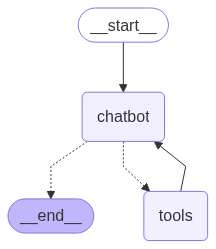

In [ ]:
from IPython.display import display, Image
Image(financial_analyst_agent.get_graph().draw_mermaid_png())

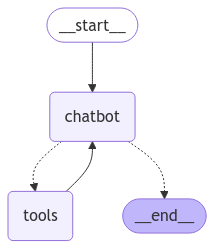

In [ ]:
# from IPython.display import display, Image

# Image(financial_analyst_agent.get_graph().draw_mermaid_png())

## Test the Agent

In [ ]:
from IPython.display import display, Markdown

response = llm.invoke('what is the PE ratio of Nvidia?')
display(Markdown(response.content))

I currently don't have real-time data access to provide the current price-to-earnings (P/E) ratio for Nvidia or any other company. To find the most up-to-date P/E ratio for Nvidia, you can check financial news websites, stock market platforms, or financial services like Bloomberg, Yahoo Finance, or Google Finance. These platforms typically provide real-time stock data, including the P/E ratio.

In [ ]:
def call_agent(agent, prompt, user_config={"configurable": {"thread_id": "any"}}):
    events = agent.stream(
        {"messages": [{"role": "user", "content": prompt}]},
        user_config,
        stream_mode="values",
    )

    for event in events:
        event["messages"][-1].pretty_print()

    print()
    print('Final Response:\n')
    display(Markdown(event["messages"][-1].content))

In [ ]:
query = 'what is the PE ratio of Nvidia?'
call_agent(financial_analyst_agent, query)

================================ Human Message =================================

what is the PE ratio of Nvidia?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_qGgkUoOrAHOYJ7Ykbhm8VIEX)
 Call ID: call_qGgkUoOrAHOYJ7Ykbhm8VIEX
  Args:
    stock_name: Nvidia
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name        |     cik |
|---:|:---------|:------------|--------:|
|  0 | NVDA     | NVIDIA CORP | 1045810 |
================================== Ai Message ==================================
Tool Calls:
  get_stock_fundamental_indicator_metrics (call_aSDSm190j3t4YGTMG78XRvJz)
 Call ID: call_aSDSm190j3t4YGTMG78XRvJz
  Args:
    stock_ticker: NVDA
================================= Tool Message =================================
Name: get_stock_fundamental_indicator_met

The P/E ratio for NVIDIA (symbol: NVDA) is 50.59 as of September 15, 2025. This represents an increase of 3.60% compared to its 12-month average P/E ratio of 48.83. A higher P/E ratio suggests that investors expect strong future earnings growth. 

For more detailed analysis, you can visit the [source](https://public.com/stocks/nvda/pe-ratio).

In [ ]:
query = 'How is Nvidia doing and it is worth investing in it or its competitors?'
call_agent(financial_analyst_agent, query)

================================ Human Message =================================

How is Nvidia doing and it is worth investing in it or its competitors?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_V7P3ByBfw3KZLaXO5MLstOQ9)
 Call ID: call_V7P3ByBfw3KZLaXO5MLstOQ9
  Args:
    stock_name: Nvidia
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name        |     cik |
|---:|:---------|:------------|--------:|
|  0 | NVDA     | NVIDIA CORP | 1045810 |
================================== Ai Message ==================================
Tool Calls:
  get_stock_price_metrics (call_2jviEXE1619FjBsTP3ZarzWy)
 Call ID: call_2jviEXE1619FjBsTP3ZarzWy
  Args:
    stock_ticker: NVDA
  get_stock_fundamental_indicator_metrics (call_s5VLoIJcc3FOgjqLE9QBNWnS)
 Call ID: call_s5VLoIJcc

### NVIDIA Corporation (NVDA) Overview

#### Stock Price Metrics
- **Current Price**: \$179.80
- **Change**: -\$3.81 (-2.08%)
- **52-Week High**: \$184.55
- **52-Week Low**: \$86.62
- **Volume**: 96,908,011
- **Market Cap**: \$4.38 trillion

#### Price Performance
- **1-Day Change**: -2.1%
- **1-Week Change**: +2.78%
- **1-Month Change**: +0.99%
- **3-Month Change**: +21.53%
- **6-Month Change**: +48.05%
- **Year-to-Date Change**: +33.85%
- **1-Year Change**: +52.5%

#### Fundamental Indicators
- **PE Ratio (Forward)**: 43.62
- **EPS (TTM)**: \$3.51
- **EPS (Forward)**: \$4.12
- **Dividend Yield**: 0.02%

#### Recent News
Unfortunately, I couldn't retrieve the latest news articles for NVIDIA at this moment.

### General Market Overview
- **Most Actively Traded Stocks**: NVIDIA, Intel, Tesla, Apple
- **Top Gainers**: BigBear.ai, Crane NXT, PDF Solutions
- **Top Losers**: Stantec Inc, Powell Industries, Dyne Therapeutics

### Investment Consideration
NVIDIA has shown strong performance over the past year with significant gains. Its forward PE ratio suggests that it is priced for growth, which is typical for tech stocks. However, the stock has recently experienced a slight decline. 

#### Competitors
- **Intel Corporation (INTC)**: Current Price: \$30, PE Ratio: 30.93
- **Tesla, Inc. (TSLA)**: Current Price: \$434.25, PE Ratio: 134.03
- **Apple Inc. (AAPL)**: Current Price: \$255.99, PE Ratio: 30.81

### Conclusion
NVIDIA remains a strong player in the tech industry, particularly in AI and graphics processing. Its competitors also show potential, each with unique strengths. It's essential to consider your investment goals and risk tolerance. I recommend conducting further research or consulting with a financial advisor before making any investment decisions.

In [ ]:
query = 'what is the PE ratio of Nvidia?'
call_agent(financial_analyst_agent, query)

================================ Human Message =================================

what is the PE ratio of Nvidia?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_AzXrNm9BZWo6Ew6eSzSU1Pwp)
 Call ID: call_AzXrNm9BZWo6Ew6eSzSU1Pwp
  Args:
    stock_name: Nvidia
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name        |     cik |
|---:|:---------|:------------|--------:|
|  0 | NVDA     | NVIDIA CORP | 1045810 |
================================== Ai Message ==================================
Tool Calls:
  get_stock_fundamental_indicator_metrics (call_Ndi8SNZ4hPfNsjMwvLHOxgWC)
 Call ID: call_Ndi8SNZ4hPfNsjMwvLHOxgWC
  Args:
    stock_ticker: NVDA
================================= Tool Message =================================
Name: get_stock_fundamental_indicator_met

The P/E ratio for NVIDIA (symbol: NVDA) is 50.59 as of September 15, 2025. This represents an increase of 3.60% compared to its 12-month average P/E ratio of 48.83. A higher P/E ratio suggests that investors expect strong future earnings growth. 

For more detailed analysis, you can visit the [source](https://public.com/stocks/nvda/pe-ratio).

In [ ]:
query = 'what is the PE ratio of Intel?'
call_agent(financial_analyst_agent, query)

================================ Human Message =================================

what is the PE ratio of Intel?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_JS0cijrzsGISgRknH8EwpjH2)
 Call ID: call_JS0cijrzsGISgRknH8EwpjH2
  Args:
    stock_name: Intel
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name                                                           |     cik |
|---:|:---------|:---------------------------------------------------------------|--------:|
|  0 | INTC     | INTEL CORP                                                     |   50863 |
|  1 | ZK       | ZEEKR Intelligent Technology Holding Ltd                       | 1954042 |
|  2 | CCCS     | CCC Intelligent Solutions Holdings Inc.                        | 1818201 |
|  3 | NIQ      | NIQ G

The current Price-to-Earnings (P/E) ratio for Intel Corporation (symbol: INTC) is approximately -5.21 as of the latest available data. This negative P/E ratio indicates that the company is currently experiencing a loss, as the earnings per share (EPS) is negative. This can be a sign of financial challenges or restructuring within the company. 

Please note that a negative P/E ratio is not typical and should be analyzed carefully in the context of the company's overall financial health and market conditions.

In [ ]:
query = 'which is better?'
call_agent(financial_analyst_agent, query)

================================ Human Message =================================

which is better?
================================== Ai Message ==================================

Could you please provide more context or specify what you are comparing? Are you asking about specific stocks, companies, or something else related to the stock market? This will help me assist you better.

Final Response:



Could you please provide more context or specify what you are comparing? Are you asking about specific stocks, companies, or something else related to the stock market? This will help me assist you better.

In [ ]:
query = 'Get detailed information of how Nvidia and Intel are doing and do a comparative analysis of which stock might be better?'
call_agent(financial_analyst_agent, query)

================================ Human Message =================================

Get detailed information of how Nvidia and Intel are doing and do a comparative analysis of which stock might be better?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_VYLfgVsdRIRjZQdkhUODy8KO)
 Call ID: call_VYLfgVsdRIRjZQdkhUODy8KO
  Args:
    stock_name: Nvidia
  get_stock_ticker_symbol (call_Y9wS8ovkTBB8QzoMmTFJ6wCW)
 Call ID: call_Y9wS8ovkTBB8QzoMmTFJ6wCW
  Args:
    stock_name: Intel
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name                                                           |     cik |
|---:|:---------|:---------------------------------------------------------------|--------:|
|  0 | INTC     | INTEL CORP                                                     | 

Here's a detailed comparison of Nvidia (NVDA) and Intel (INTC) based on the available stock price metrics:

### Nvidia (NVDA)
- **Current Price**: \$179.60
- **Price Change**: -2.18% over the last day
- **Year High/Low**: \$184.55 / \$86.62
- **Volume**: 97.76 million
- **Performance**:
  - 1 Week: +2.70%
  - 1 Month: +0.90%
  - 3 Months: +21.43%
  - 1 Year: +52.37%
- **Volatility**:
  - Weekly: 2.86%
  - Monthly: 2.64%

### Intel (INTC)
- **Current Price**: \$29.87
- **Price Change**: +3.85% over the last day
- **Year High/Low**: \$32.38 / \$17.67
- **Volume**: 69.14 million
- **Performance**:
  - 1 Week: +18.38%
  - 1 Month: +20.63%
  - 3 Months: +32.66%
  - 1 Year: +41.51%
- **Volatility**:
  - Weekly: 4.50%
  - Monthly: 3.46%

### Comparative Analysis
- **Growth**: Nvidia has shown significant growth over the past year with a 52.37% increase, while Intel has also performed well with a 41.51% increase.
- **Volatility**: Intel exhibits higher volatility compared to Nvidia, which may indicate more risk but also potential for higher returns.
- **Recent Performance**: Intel has outperformed Nvidia in the short term, with a higher percentage increase over the past week and month.

### Conclusion
Both Nvidia and Intel have shown strong performance, but they cater to different investor profiles. Nvidia may appeal to those looking for a more stable growth trajectory, while Intel might attract those willing to take on more risk for potentially higher short-term gains. As always, it's important to conduct further research and consider your own risk tolerance and investment goals before making a decision.

We have successfully built an AI Agent which can do detailed financial analysis for us but it is not yet conversational. We will add in the that functionality in the next videos